# Rolling Planning mit Tardiness (Max)

In [1]:
import time

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 20)

In [3]:
import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

In [5]:
max_time = 60*60*6 # 6h

## Generierung des Datensatzes für 8 Tage (Ankunft)

In [6]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 8,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1515,Job_151,5,M9,76
1516,Job_151,6,M5,47
1517,Job_151,7,M3,52
1518,Job_151,8,M4,90


In [7]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0, buffer_factor=1.2)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,1381.052676
1,Job_001,83.42,1866.551303
2,Job_002,144.74,2130.658784
3,Job_003,197.03,2487.130006
4,Job_004,233.63,1607.690004
...,...,...,...
147,Job_147,11208.21,13498.310006
148,Job_148,11214.27,12588.330004
149,Job_149,11215.63,13201.548784
150,Job_150,11334.35,12715.402676


## Params

In [8]:
# fix
day_length = 1440
horizon_days = 3

In [9]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [10]:
day_numb = 0

In [11]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [12]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [13]:
df_times_curr 

,Job,Arrival,Deadline
0,Job_000,0.00,1381.052676
1,Job_001,83.42,1866.551303
2,Job_002,144.74,2130.658784
3,Job_003,197.03,2487.130006
4,Job_004,233.63,1607.690004
...,...,...,...
52,Job_052,4008.21,6298.310006
53,Job_053,4014.27,5388.330004
54,Job_054,4015.63,6001.548784
55,Job_055,4134.35,5515.402676


### Scheduling

In [14]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_jssp_max_tardiness(df_jssp_curr, df_times_curr, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.075)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 16000

Solver-Informationen:
  Maximale Tardiness      : 272.4186
  Solver-Status           : Optimal
  Anzahl Variablen        : 16645
  Anzahl Constraints      : 32604

Scheduling-Dauer: 360 Minuten und 1.05 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1381.052676,M0,0.00,29.0,29.00,0.00
1,Job_000,1,0.00,1381.052676,M1,29.00,78.0,107.00,0.00
2,Job_001,0,83.42,1866.551303,M0,83.42,43.0,126.42,0.00
3,Job_000,2,0.00,1381.052676,M2,107.00,9.0,116.00,0.00
4,Job_000,3,0.00,1381.052676,M3,116.00,36.0,152.00,0.00
...,...,...,...,...,...,...,...,...,...
565,Job_056,8,4234.37,6122.391379,M4,6259.81,90.0,6349.81,227.42
566,Job_052,7,4008.21,6298.310006,M3,6313.81,98.0,6411.81,113.50
567,Job_056,9,4234.37,6122.391379,M7,6349.81,45.0,6394.81,272.42
568,Job_052,8,4008.21,6298.310006,M9,6411.81,22.0,6433.81,135.50


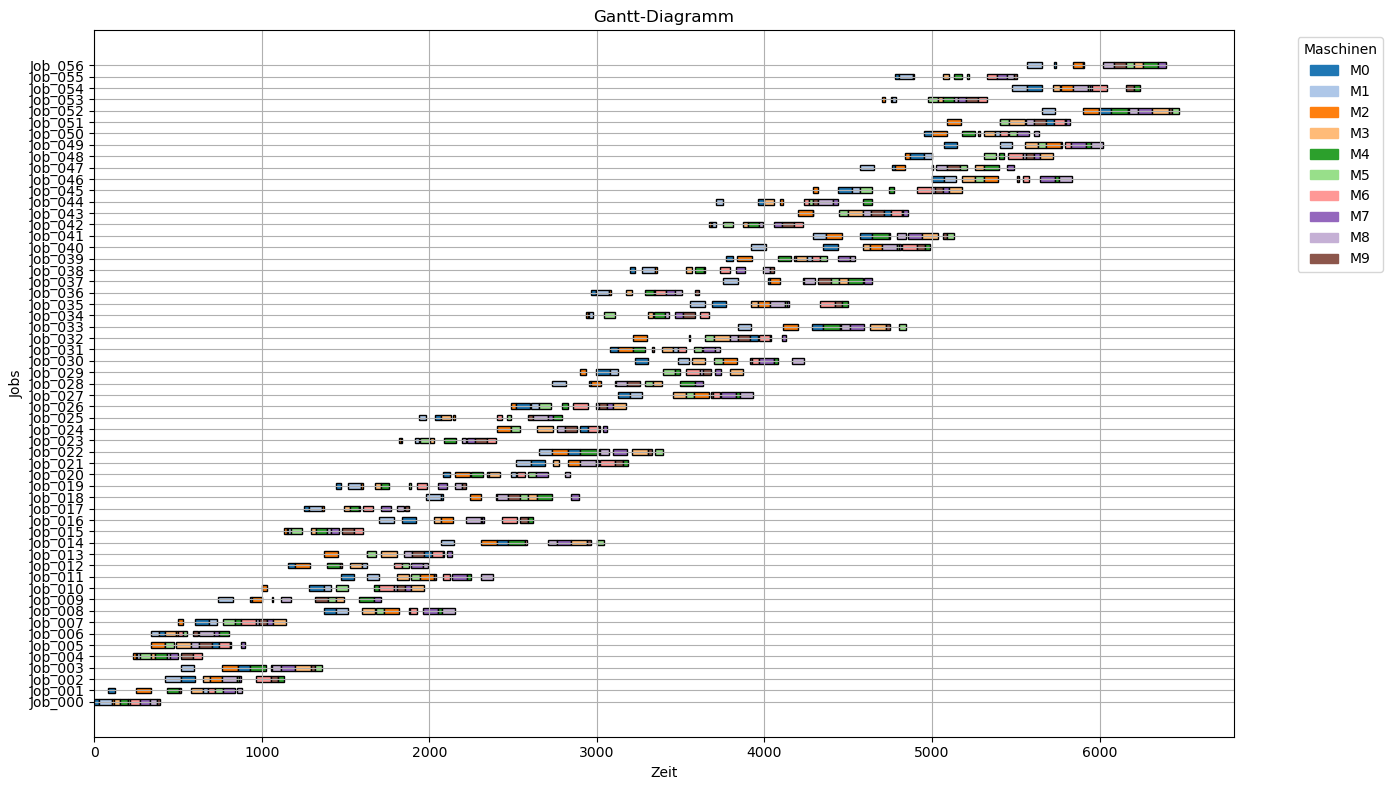

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [15]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [17]:
show.count_column_grouped(df_plan, 'Tardiness')

<0             0
0            546
0-30           2
30-60          6
60-120         7
120-240        8
240-480        1
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int64

### Simulation

In [18]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:23:25] Job_001 started on M0
[01:58:45] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:05:27] Job_000 finished on M1 (after 96 minutes 28 seconds)
[02:05:27] Job_000 started on M2
[02:13:04] Job_000 finished on M2 (after 07 minutes 37 seconds)
[02:13:04] Job_000 started on M3
[02:38:45] Job_000 finished on M3 (after 25 minutes 41 seconds)
[02:38:45] Job_000 started on M4
[03:46:06] Job_000 finished on M4 (after 67 minutes 22 seconds)
[03:46:06] Job_000 started on M5
[03:53:37] Job_004 started on M2
[04:02:28] Job_000 finished on M5 (after 16 minutes 22 seconds)
[04:02:28] Job_000 started on M6
[04:12:48] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:12:48] Job_001 started on M2
[04:12:48] Job_004 started on M0
[04:20:36] Job_004 finished on M0 (after 07 minutes 48 seconds)
[04:20:36] Job_004 started on M1
[04:38:48] Job_004 finished 

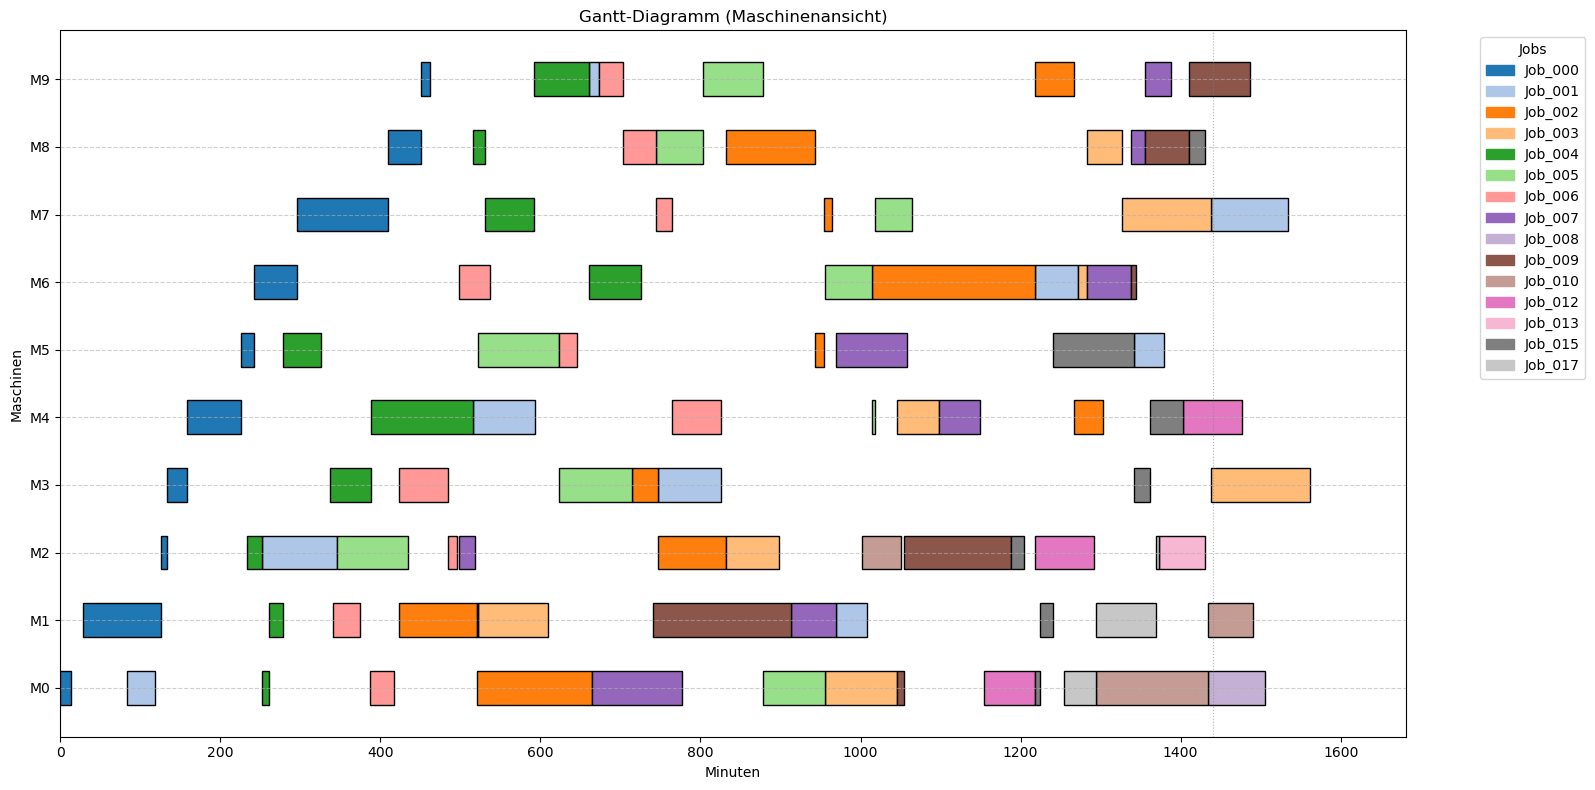

In [19]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [20]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_001,9,83.42,M8,851.81,30.0
1,Job_007,8,488.49,M7,1029.81,36.0
2,Job_007,9,488.49,M3,1065.81,79.0
3,Job_003,8,197.03,M9,1295.81,22.0
4,Job_003,9,197.03,M5,1317.81,43.0
...,...,...,...,...,...,...
466,Job_056,8,4234.37,M4,6259.81,90.0
467,Job_052,7,4008.21,M3,6313.81,98.0
468,Job_056,9,4234.37,M7,6349.81,45.0
469,Job_052,8,4008.21,M9,6411.81,22.0


#### Export

In [21]:
df_jssp.to_csv("data/05_tardiness_all_jssp.csv", index = False)
df_times.to_csv("data/05_tardiness_all_times.csv", index = False)

In [22]:
df_plan.to_csv("data/05_tardiness_init_plan.csv", index = False)
df_execution.to_csv("data/05_tardiness_execution.csv", index = False)
df_undone.to_csv("data/05_tardiness_init_undone.csv", index = False)